In [5]:
import pandas as pd
import numpy as np
import re
from typing import List, Dict, Set, Tuple
from collections import defaultdict, Counter
from rapidfuzz import fuzz, process
from googletrans import Translator
import langdetect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

print("라이브러리 임포트 완료!")

라이브러리 임포트 완료!


전처리기 클래스 정의

In [6]:
class ShipSupplyPreprocessor:
    """선박용품 도메인 특화 전처리기 - 완전 데이터 기반 학습"""
    
    def __init__(self, df: pd.DataFrame):
        self.df = df
        self.translator = Translator()
        
        print("데이터에서 패턴 학습 중...")
        
        # 데이터에서 모든 패턴 자동 학습
        self.learn_from_data()
        
        print("전처리기 학습 완료")
        
    def learn_from_data(self):
        """데이터에서 모든 패턴을 자동으로 학습"""
        
        # 1. 단위 패턴 학습
        print("  1. 단위 패턴 학습 중...")
        self.unit_patterns = self._learn_unit_patterns()
        
        # 2. 복합어 패턴 학습
        print(" 2. 복합어 패턴 학습 중...")
        self.compound_patterns = self._learn_compound_patterns()
        
        # 3. 동의어 관계 학습
        print(" 3. 동의어 관계 학습 중...")
        self.synonyms = self._learn_synonyms()
        
        # 4. 오타 보정을 위한 어휘 빈도 학습
        print(" 4. 어휘 빈도 학습 중...")
        self.vocabulary_freq = self._learn_vocabulary_frequency()
        
        # 5. 카테고리 구조 학습
        print(" 5. 카테고리 구조 학습 중...")
        self.category_structure = self._learn_category_structure()
        
        # 6. 문맥 기반 단어 관계 학습
        print(" 6. 문맥 정보 학습 중...")
        self.word_context = self._learn_word_context()
    
    def _learn_unit_patterns(self) -> Dict[str, str]:
        """데이터에서 단위 패턴 자동 학습 - 빈도 기반 표준 선택"""
        unit_patterns = {}
        
        # L5 (규격) 컬럼에서 패턴 추출
        if 'L5 NAME (SPEC)' in self.df.columns:
            specs = self.df['L5 NAME (SPEC)'].dropna().astype(str)
            
            # 모든 숫자+단위 패턴 수집
            unit_variations = defaultdict(lambda: defaultdict(int))
            
            for spec in specs:
                # 숫자와 단위 찾기 (예: 750ML, 1L, 12BTL)
                matches = re.findall(r'(\d+)\s*([A-Z]+)', spec)
                for num, unit in matches:
                    # 단위의 기본형 추정 (공통 부분 찾기)
                    # ML, MLS, MLX → ML 그룹
                    # LTR, LTRS, L → L 그룹
                    base_unit = self._find_base_unit(unit)
                    unit_variations[base_unit][unit] += 1
            
            # 각 단위 그룹에서 가장 빈번한 형태를 표준으로 선택
            for base_unit, variations in unit_variations.items():
                if len(variations) > 1:
                    # 가장 빈번한 형태를 표준으로
                    standard = max(variations.items(), key=lambda x: x[1])[0]
                    
                    # 다른 변형들을 표준으로 변환하는 패턴 생성
                    for variant, count in variations.items():
                        if variant != standard:
                            pattern = rf'\b(\d+)\s*{re.escape(variant)}\b'
                            replacement = rf'\1{standard}'
                            unit_patterns[pattern] = replacement
        
        # 연도 패턴 (12Y → 12YEAR) - 데이터에서 YEAR가 더 많이 사용되는지 확인
        year_variations = defaultdict(int)
        for text in self.df.values.flatten():
            if pd.notna(text):
                # Y, YR, YEAR 등의 변형 찾기
                for match in re.findall(r'\b\d+\s*([Y](?:EAR|R)?S?)\b', str(text), re.IGNORECASE):
                    year_variations[match.upper()] += 1
        
        if year_variations:
            # 가장 빈번한 연도 표현을 표준으로
            standard_year = max(year_variations.items(), key=lambda x: x[1])[0]
            for variant in year_variations:
                if variant != standard_year:
                    pattern = rf'\b(\d+)\s*{re.escape(variant)}\b'
                    replacement = rf'\1{standard_year}'
                    unit_patterns[pattern] = replacement
        
        return unit_patterns
    
    def _find_base_unit(self, unit: str) -> str:
        """단위의 기본형 찾기 (ML, MLS → ML 그룹)"""
        # 일반적인 단위 패턴
        common_bases = {
            'ML': ['ML', 'MLS', 'MLX', 'MLTS'],
            'L': ['L', 'LT', 'LTR', 'LTRS', 'LTRX', 'LITRE', 'LITER'],
            'KG': ['KG', 'KGS', 'KILO', 'KILOGRAM'],
            'G': ['G', 'GR', 'GRAM', 'GMS'],
            'M': ['M', 'MT', 'MTR', 'METER', 'METRE'],
            'CM': ['CM', 'CMS', 'CENTIMETER'],
            'MM': ['MM', 'MMS', 'MILLIMETER'],
            'PC': ['PC', 'PCS', 'PIECE', 'PIECES'],
            'BOX': ['BOX', 'BX', 'BOXES'],
            'BTL': ['BTL', 'BOTTLE', 'BOTTLES'],
            'CAN': ['CAN', 'CANS'],
            'PKT': ['PKT', 'PACKET', 'PACKETS', 'PACK'],
            'SET': ['SET', 'SETS'],
            'PAIR': ['PAIR', 'PAIRS', 'PR'],
            'DOZ': ['DOZ', 'DOZEN', 'DZ'],
            'ROLL': ['ROLL', 'ROLLS', 'RL'],
            'SHEET': ['SHEET', 'SHEETS', 'SHT'],
            'YEAR': ['Y', 'YR', 'YEAR', 'YEARS']
        }
        
        # 단위가 어느 그룹에 속하는지 찾기
        unit_upper = unit.upper()
        for base, variations in common_bases.items():
            if unit_upper in variations:
                return base
        
        # 못 찾으면 원래 단위 반환
        return unit_upper
    
    def _learn_compound_patterns(self) -> Dict[str, List[str]]:
        """데이터에서 복합어 패턴 자동 학습"""
        compound_patterns = defaultdict(list)
        
        # 모든 카테고리명에서 복합어 패턴 추출
        all_names = []
        for col in ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME']:
            if col in self.df.columns:
                all_names.extend(self.df[col].dropna().astype(str).tolist())
        
        # 빈도 계산을 위한 카운터
        name_counter = Counter(all_names)
        
        # 2개 이상의 단어로 구성된 용어 찾기
        for name in set(all_names):
            words = name.split()
            if len(words) >= 2:
                # 이 복합어가 데이터에 얼마나 자주 나타나는지
                compound_count = name_counter[name]
                
                # 각 단어가 개별적으로 나타나는 빈도
                individual_counts = []
                for word in words:
                    word_count = sum(1 for n in all_names if word in n.split())
                    individual_counts.append(word_count)
                
                # 복합어로 더 자주 나타나면 복합어로 처리
                # (복합어 빈도가 개별 단어 최소 빈도의 30% 이상)
                if compound_count > min(individual_counts) * 0.3:
                    compound_patterns[name] = words
        
        return dict(compound_patterns)
    
    def _learn_synonyms(self) -> Dict[str, Set[str]]:
        """데이터에서 동의어 관계 자동 학습"""
        synonyms = defaultdict(set)
        
        # 1. 슬래시로 구분된 동의어
        for col in ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME']:
            if col in self.df.columns:
                for name in self.df[col].dropna().unique():
                    if '/' in str(name):
                        parts = [p.strip() for p in str(name).split('/')]
                        for part in parts:
                            synonyms[part].update(parts)
        
        # 2. 같은 상위 카테고리를 공유하는 유사 단어들
        category_words = defaultdict(lambda: defaultdict(int))
        
        for _, row in self.df.iterrows():
            if pd.notna(row.get('L1 NAME')) and pd.notna(row.get('L2 NAME')):
                l1 = str(row['L1 NAME'])
                l2_words = str(row['L2 NAME']).split()
                
                for word in l2_words:
                    if len(word) > 3:  # 의미있는 길이의 단어만
                        category_words[l1][word] += 1
        
        # 같은 카테고리에서 자주 나타나는 단어들을 동의어로
        for category, words in category_words.items():
            word_list = [w for w, count in words.items() if count > 5]
            
            # 편집 거리가 가까운 단어들을 동의어로
            for i, word1 in enumerate(word_list):
                for word2 in word_list[i+1:]:
                    similarity = fuzz.ratio(word1, word2)
                    if similarity > 80:  # 80% 이상 유사
                        synonyms[word1].add(word2)
                        synonyms[word2].add(word1)
        
        # 3. 일반적인 동의어 패턴 (CIGARETTE/CIGARETE 같은)
        all_words = set()
        for col in self.df.columns:
            if 'NAME' in col:
                words = self.df[col].dropna().astype(str).str.split().explode()
                all_words.update(words)
        
        # 편집거리 1-2인 단어들 중 하나가 훨씬 빈번하면 동의어로
        word_freq = Counter()
        for word in all_words:
            word_freq[word] += 1
        
        for word1, freq1 in word_freq.most_common(500):
            for word2, freq2 in word_freq.items():
                if word1 != word2 and 1 <= len(word1) - len(word2) <= 2:
                    if fuzz.ratio(word1, word2) > 85 and freq1 > freq2 * 5:
                        synonyms[word2].add(word1)
        
        return dict(synonyms)
    
    def _learn_vocabulary_frequency(self) -> Dict[str, int]:
        """어휘 빈도 학습 (오타 보정용)"""
        word_freq = Counter()
        
        # 모든 텍스트에서 단어 빈도 계산
        for col in self.df.columns:
            if 'NAME' in col or 'CODE' in col:
                for text in self.df[col].dropna().astype(str):
                    words = text.split()
                    word_freq.update(words)
        
        return dict(word_freq)
    
    def _learn_category_structure(self) -> Dict:
        """카테고리 계층 구조 학습"""
        structure = {
            'hierarchy': defaultdict(lambda: defaultdict(set)),
            'level_words': defaultdict(set),
            'level_importance': {}  # 각 레벨의 중요도
        }
        
        # 계층 관계 학습
        for _, row in self.df.iterrows():
            for i, level in enumerate(['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME']):
                if level in row and pd.notna(row[level]):
                    current = str(row[level])
                    
                    # 현재 레벨의 단어들 저장
                    words = current.split()
                    structure['level_words'][level].update(words)
                    
                    # 상위 레벨과의 관계 저장
                    if i > 0:
                        prev_level = ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME'][i-1]
                        if prev_level in row and pd.notna(row[prev_level]):
                            parent = str(row[prev_level])
                            structure['hierarchy'][parent][level].add(current)
        
        # 레벨별 중요도 계산 (상위 레벨일수록 중요)
        level_weights = {'L1 NAME': 4, 'L2 NAME': 3, 'L3 NAME': 2, 'L4 NAME': 1, 'L5 NAME (SPEC)': 0.5}
        structure['level_importance'] = level_weights
        
        return structure
    
    def _learn_word_context(self) -> Dict:
        """단어의 문맥 정보 학습 (TF-IDF 기반)"""
        # 모든 텍스트 수집
        texts = []
        text_levels = []  # 텍스트가 어느 레벨에서 왔는지
        
        for col in ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME']:
            if col in self.df.columns:
                col_texts = self.df[col].dropna().astype(str).tolist()
                texts.extend(col_texts)
                text_levels.extend([col] * len(col_texts))
        
        if not texts:
            return {}
        
        # TF-IDF 벡터화
        vectorizer = TfidfVectorizer(
            ngram_range=(1, 2),  # unigram + bigram
            max_features=1000,
            min_df=2,
            max_df=0.8
        )
        
        try:
            tfidf_matrix = vectorizer.fit_transform(texts)
            feature_names = vectorizer.get_feature_names_out()
            
            # 단어별 중요도 점수
            word_importance = {}
            for idx, word in enumerate(feature_names):
                importance = tfidf_matrix[:, idx].sum()
                word_importance[word] = float(importance)
            
            return {
                'vectorizer': vectorizer,
                'tfidf_matrix': tfidf_matrix,
                'word_importance': word_importance,
                'texts': texts,
                'text_levels': text_levels
            }
        except:
            return {}
    
    def normalize_text(self, text: str) -> str:
        """학습된 패턴 기반 텍스트 정규화"""
        if pd.isna(text):
            return ""
    
        text = str(text).upper().strip()
    
        # 1. 학습된 단위 패턴 적용
        for pattern, replacement in self.unit_patterns.items():
            # 1X12 같은 패턴 보호
            if 'X' in pattern and re.search(r'\d+X\d+', text):
                continue
        
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)
    
        # 2. 특수문자 정리 (슬래시, 하이픈, &는 유지)
        text = re.sub(r'[^\w\s/\-&]', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
    
        return text
    
    def smart_correct(self, query: str, threshold: float = 0.8) -> str:
        """학습된 어휘 기반 스마트 보정"""
        words = query.split()
        corrected_words = []
        
        
        for word in words:
            # 빈도수가 높은 단어는 그대로 유지
            if word in self.vocabulary_freq and self.vocabulary_freq[word] > 10:
                corrected_words.append(word)
                continue
            
            # 빈도수가 낮거나 없는 단어는 유사 단어 찾기
            candidates = []
            if word.isdigit() or re.search(r'\d', word):
                corrected_words.append(word)
                continue
            # 복합어(언더스코어 포함)는 보정하지 않음
            if '_' in word:
                corrected_words.append(word)
                continue
            
            # 먼저 동의어 확인
            if word in self.synonyms and self.synonyms[word]:
                # 동의어 중 가장 빈번한 것 선택
                best_synonym = max(self.synonyms[word], 
                                 key=lambda x: self.vocabulary_freq.get(x, 0))
                corrected_words.append(best_synonym)
                continue
            
            # 유사 단어 찾기
            for vocab_word, freq in self.vocabulary_freq.items():
                # 길이가 비슷한 단어만 비교 (효율성)
                if abs(len(vocab_word) - len(word)) <= 2:
                    similarity = fuzz.ratio(word, vocab_word) / 100.0
                    if similarity >= threshold:
                        # 빈도수를 가중치로 사용
                        score = similarity * np.log(freq + 1)
                        candidates.append((vocab_word, score))
            
            if candidates:
                # 가장 높은 점수의 단어 선택
                best_word = max(candidates, key=lambda x: x[1])[0]
                corrected_words.append(best_word)
            else:
                corrected_words.append(word)
        
        return ' '.join(corrected_words)
    
    def detect_compound_words(self, query: str) -> str:
        """학습된 복합어 패턴 감지 및 처리"""
        # 쿼리에 포함된 복합어 찾기
        query_words = query.split()
        
        for compound, compound_words in sorted(self.compound_patterns.items(), 
                                              key=lambda x: len(x[1]), reverse=True):
            # 모든 구성 단어가 순서대로 있는지 확인
            for i in range(len(query_words) - len(compound_words) + 1):
                if query_words[i:i+len(compound_words)] == compound_words:
                    # 복합어로 대체 (언더스코어로 연결)
                    new_query_words = (query_words[:i] + 
                                     ['_'.join(compound_words)] + 
                                     query_words[i+len(compound_words):])
                    query = ' '.join(new_query_words)
                    query_words = new_query_words
                    break
        
        return query
    
    def translate_if_korean(self, text: str) -> str:
        """한글 감지 및 번역"""
        try:
            if re.search('[가-힣]', text):
                result = self.translator.translate(text, src='ko', dest='en')
                return result.text.upper()
        except:
            pass
        return text
    
    def context_aware_expansion(self, query: str) -> List[str]:
        """문맥 기반 쿼리 확장"""
        expanded = [query]
        
        # 1. 학습된 동의어 확장
        words = query.split()
        for word in words:
            if word in self.synonyms:
                for synonym in self.synonyms[word]:
                    new_query = query.replace(word, synonym)
                    if new_query not in expanded:
                        expanded.append(new_query)
        
        # 2. TF-IDF 기반 유사 문맥 찾기
        if hasattr(self, 'word_context') and 'vectorizer' in self.word_context:
            try:
                query_vec = self.word_context['vectorizer'].transform([query])
                similarities = cosine_similarity(query_vec, self.word_context['tfidf_matrix'])[0]
                
                # 상위 유사 텍스트 찾기
                top_indices = similarities.argsort()[-3:][::-1]
                for idx in top_indices:
                    if similarities[idx] > 0.3:
                        similar_text = self.word_context['texts'][idx]
                        if similar_text not in expanded and len(expanded) < 5:
                            expanded.append(similar_text)
            except:
                pass
        
        return expanded[:5]
    
    def preprocess_query(self, query: str, verbose: bool = False) -> str:
        """쿼리 전처리 메인 함수 - 완전 학습 기반"""
        steps = []
        current = query
        
        # 1. 기본 정규화
        normalized = self.normalize_text(current)
        if normalized != current:
            steps.append(('정규화', normalized))
            current = normalized
        
        # 2. 한글 번역
        translated = self.translate_if_korean(current)
        if translated != current:
            steps.append(('번역', translated))
            current = translated
        
        # 3. 복합어 감지
        compound_detected = self.detect_compound_words(current)
        if compound_detected != current:
            steps.append(('복합어', compound_detected))
            current = compound_detected
        
        # 4. 스마트 보정
        corrected = self.smart_correct(current)
        if corrected != current:
            steps.append(('보정', corrected))
            current = corrected
        
        # 5. 복합어 원복 (언더스코어 제거)
        final = current.replace('_', ' ')
        if final != current:
            steps.append(('최종', final))
        
        if verbose:
            print(f"전처리 과정: {query}")
            for step_name, result in steps:
                print(f"   → {step_name}: {result}")
            if not steps:
                print(f"   → 변경 없음: {query}")
        
        return final
    
    def create_search_text(self, row: pd.Series) -> str:
        """검색용 텍스트 생성 - 학습된 중요도 기반"""
        parts = []
        weights = []
        
        # 각 레벨의 텍스트와 중요도 계산
        for level in ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME', 'L5 NAME (SPEC)']:
            if level in row and pd.notna(row[level]) and row[level]:
                text = str(row[level])
                parts.append(text)
                
                # 레벨별 가중치 적용
                if hasattr(self, 'category_structure'):
                    level_weight = self.category_structure['level_importance'].get(level, 1)
                    
                    # 단어 중요도도 고려
                    if hasattr(self, 'word_context') and 'word_importance' in self.word_context:
                        words = text.lower().split()
                        word_importance = sum(
                            self.word_context['word_importance'].get(word, 0) 
                            for word in words
                        ) / len(words) if words else 0
                        
                        # 최종 가중치 = 레벨 가중치 × 단어 중요도
                        final_weight = level_weight * (1 + word_importance)
                    else:
                        final_weight = level_weight
                    
                    # 가중치에 따라 반복
                    repeat_count = max(1, int(final_weight))
                    weights.extend([text] * repeat_count)
        
        # P CODE 추가
        if 'P CODE' in row and pd.notna(row['P CODE']):
            parts.append(str(row['P CODE']))
        
        # 조합
        combined = ' | '.join(parts)
        if weights:
            weighted_text = ' '.join(weights)
            combined = f"{combined} {weighted_text}"
        
        return self.normalize_text(combined)
    
    def get_preprocessing_stats(self) -> Dict:
        """학습된 전처리 통계 반환"""
        stats = {
            '학습된 단위 패턴': len(self.unit_patterns),
            '학습된 복합어': len(self.compound_patterns),
            '학습된 동의어 그룹': len(self.synonyms),
            '학습된 어휘 수': len(self.vocabulary_freq),
            '가장 빈번한 단어 Top10': Counter(self.vocabulary_freq).most_common(10)
        }
        
        # 학습된 패턴 예시
        if self.unit_patterns:
            stats['단위 패턴 예시'] = list(self.unit_patterns.items())[:5]
        if self.compound_patterns:
            stats['복합어 예시'] = list(self.compound_patterns.items())[:5]
        if self.synonyms:
            stats['동의어 예시'] = [(k, list(v)[:3]) for k, v in 
                                  list(self.synonyms.items())[:5]]
        
        return stats

전처리기 생성

In [7]:
# 데이터 로드 (이전에 로드한 df 사용)
df = pd.read_excel("선용품 표준코드 목록 - ALL.xlsx")

# 전처리기 생성 (자동 학습)
preprocessor = ShipSupplyPreprocessor(df)

# 학습 통계 확인
stats = preprocessor.get_preprocessing_stats()
print("학습 통계:\n")
for key, value in stats.items():
    if isinstance(value, list) and len(value) > 0 and isinstance(value[0], tuple):
        print(f"✓ {key}:")
        for item in value[:5]:
            print(f"   - {item}")
    else:
        print(f"✓ {key}: {value}")

데이터에서 패턴 학습 중...
  1. 단위 패턴 학습 중...
 2. 복합어 패턴 학습 중...
 3. 동의어 관계 학습 중...
 4. 어휘 빈도 학습 중...
 5. 카테고리 구조 학습 중...
 6. 문맥 정보 학습 중...
전처리기 학습 완료
학습 통계:

✓ 학습된 단위 패턴: 12
✓ 학습된 복합어: 14643
✓ 학습된 동의어 그룹: 3736
✓ 학습된 어휘 수: 135400
✓ 가장 빈번한 단어 Top10:
   - ('/', 44783)
   - ('STEEL', 20744)
   - ('TOOL', 14341)
   - ('EQUIPMENT', 13265)
   - ('VALVE', 9241)
✓ 단위 패턴 예시:
   - ('\\b(\\d+)\\s*L\\b', '\\1LTR')
   - ('\\b(\\d+)\\s*LTRX\\b', '\\1LTR')
   - ('\\b(\\d+)\\s*LTRS\\b', '\\1LTR')
   - ('\\b(\\d+)\\s*LT\\b', '\\1LTR')
   - ('\\b(\\d+)\\s*MLX\\b', '\\1ML')
✓ 복합어 예시:
   - ('FAUCET BATH/SHOWER SA545025, W/S SWIVEL SPOUT ', ['FAUCET', 'BATH/SHOWER', 'SA545025,', 'W/S', 'SWIVEL', 'SPOUT'])
   - ('NON-SLIP COATING 1GAL, FOR FLOOR', ['NON-SLIP', 'COATING', '1GAL,', 'FOR', 'FLOOR'])
   - ('ULTRA HIGH PRESSURE WATER BLASTERS', ['ULTRA', 'HIGH', 'PRESSURE', 'WATER', 'BLASTERS'])
   - ('CHINGGIS KHAN', ['CHINGGIS', 'KHAN'])
   - ("U-BOLTS SHIP'S STEEL PIPE", ['U-BOLTS', "SHIP'S", 'STEEL', 'PIPE'])
✓ 동의어 예시

In [8]:
# 전처리 테스트
test_queries = [
    "DECK EQUIPMENT",
    "PAINT BRUSH", 
    "750 ML WHISKY",
    "CIGARETE",  # 오타
    "안전장비",
    "CHIVAS REGAL 18Y",
    "MOLYKOTE GREASE",
    "SAFTY EQUIPMENT",  # 오타
    "life jacket",  # 소문자
    "1X12 BOTTLES"
]

print("전처리 테스트:\n")
for query in test_queries:
    processed = preprocessor.preprocess_query(query, verbose=True)
    print(f"최종: {processed}\n")
    print("-" * 60 + "\n")

전처리 테스트:

전처리 과정: DECK EQUIPMENT
   → 변경 없음: DECK EQUIPMENT
최종: DECK EQUIPMENT

------------------------------------------------------------

전처리 과정: PAINT BRUSH
   → 변경 없음: PAINT BRUSH
최종: PAINT BRUSH

------------------------------------------------------------

전처리 과정: 750 ML WHISKY
   → 변경 없음: 750 ML WHISKY
최종: 750 ML WHISKY

------------------------------------------------------------

전처리 과정: CIGARETE
   → 보정: CIGARETTE
최종: CIGARETTE

------------------------------------------------------------

전처리 과정: 안전장비
   → 번역: SAFETY EQUIPMENT
   → 복합어: SAFETY_EQUIPMENT
   → 최종: SAFETY EQUIPMENT
최종: SAFETY EQUIPMENT

------------------------------------------------------------

전처리 과정: CHIVAS REGAL 18Y
   → 복합어: CHIVAS_REGAL_18Y
   → 최종: CHIVAS REGAL 18Y
최종: CHIVAS REGAL 18Y

------------------------------------------------------------

전처리 과정: MOLYKOTE GREASE
   → 변경 없음: MOLYKOTE GREASE
최종: MOLYKOTE GREASE

------------------------------------------------------------

전처리 과정: SAFTY EQUIPM

In [9]:
# 쿼리 확장 테스트
print("쿼리 확장 테스트:\n")
test_expansion = ["SAFETY EQUIPMENT", "WHISKY", "CLEANING MATERIAL"]

for query in test_expansion:
    processed = preprocessor.preprocess_query(query)
    expanded = preprocessor.context_aware_expansion(processed)
    
    print(f"원본: {query}")
    print(f"전처리: {processed}")
    print(f"확장: {expanded}")
    print("-" * 40 + "\n")

쿼리 확장 테스트:

원본: SAFETY EQUIPMENT
전처리: SAFETY EQUIPMENT
확장: ['SAFETY EQUIPMENT']
----------------------------------------

원본: WHISKY
전처리: WHISKY
확장: ['WHISKY', 'WHISKY CUTTY SARK NRF']
----------------------------------------

원본: CLEANING MATERIAL
전처리: CLEANING MATERIAL
확장: ['CLEANING MATERIAL', 'CLEANING MATERIAL / CHEMICAL']
----------------------------------------



학습 패턴 시각화

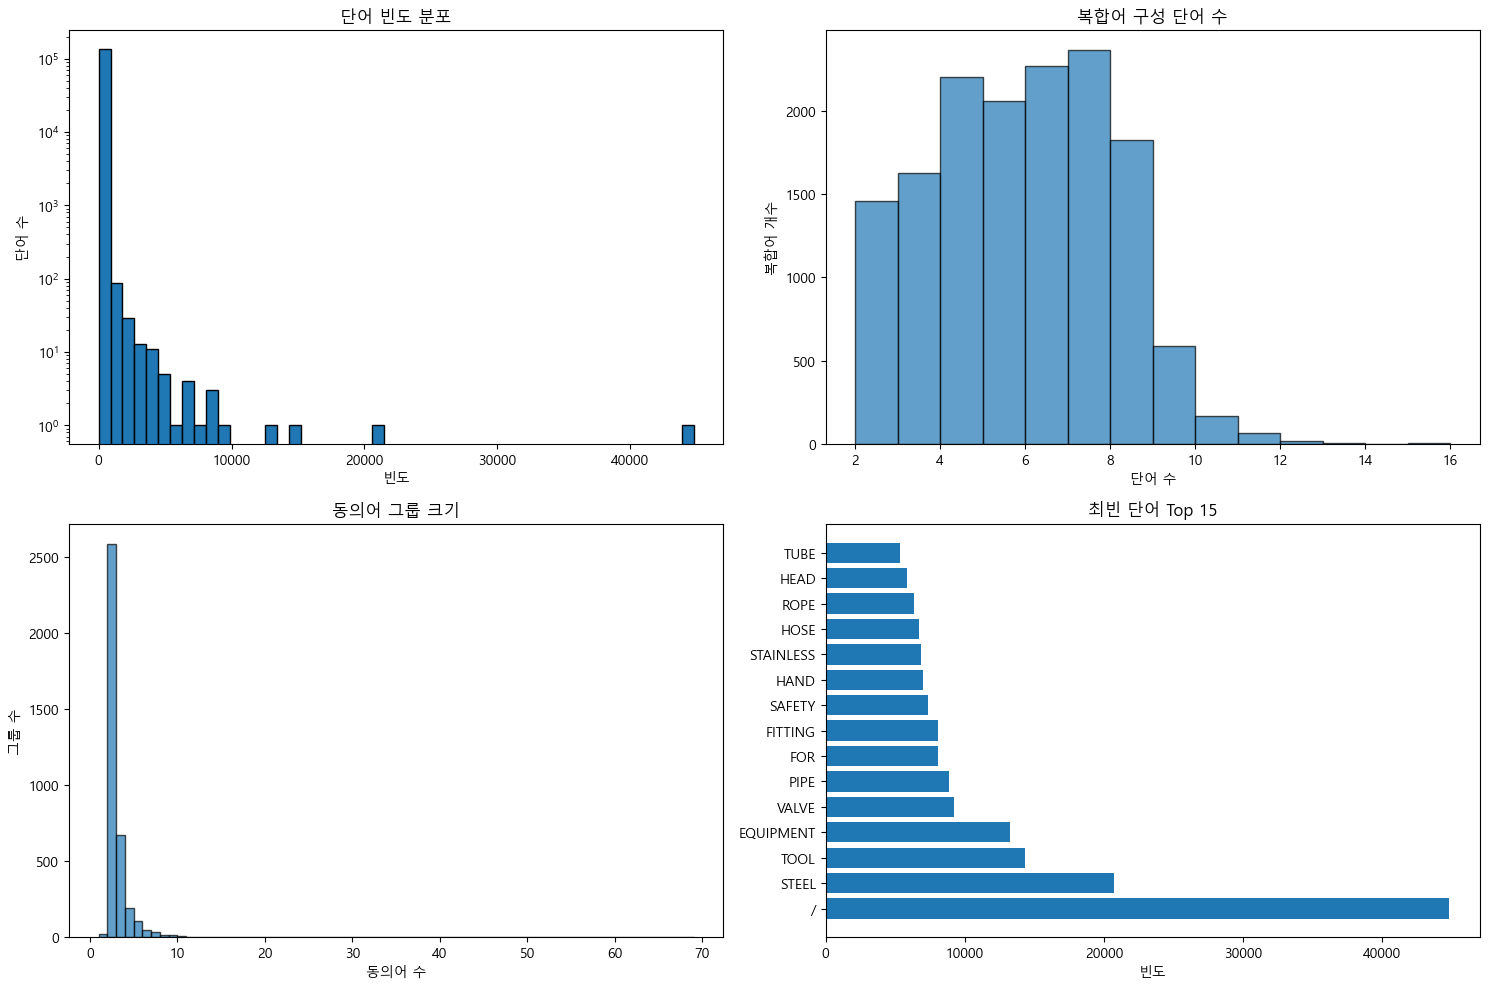


전처리기 학습 완료!
  - 총 135400 개의 단어 학습
  - 14643 개의 복합어 패턴 발견
  - 3736 개의 동의어 그룹 생성
  - 12 개의 단위 정규화 패턴 학습


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'  # 기본 폰트
plt.rcParams['axes.unicode_minus'] = False   # 마이너스 기호 깨짐 방지

# OS별 한글 폰트 설정
import platform
system = platform.system()

if system == 'Windows':
    rc('font', family='Malgun Gothic')
elif system == 'Darwin':  # macOS
    rc('font', family='AppleGothic')
else:  # Linux
    rc('font', family='NanumGothic')

# 학습된 패턴 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. 단어 빈도 분포
word_freq_values = list(preprocessor.vocabulary_freq.values())
axes[0, 0].hist(word_freq_values, bins=50, edgecolor='black')
axes[0, 0].set_title('단어 빈도 분포')
axes[0, 0].set_xlabel('빈도')
axes[0, 0].set_ylabel('단어 수')
axes[0, 0].set_yscale('log')

# 2. 복합어 길이 분포
compound_lengths = [len(words) for words in preprocessor.compound_patterns.values()]
if compound_lengths:
    axes[0, 1].hist(compound_lengths, bins=range(2, max(compound_lengths)+2), 
                    edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('복합어 구성 단어 수')
    axes[0, 1].set_xlabel('단어 수')
    axes[0, 1].set_ylabel('복합어 개수')

# 3. 동의어 그룹 크기
synonym_sizes = [len(syns) for syns in preprocessor.synonyms.values()]
if synonym_sizes:
    axes[1, 0].hist(synonym_sizes, bins=range(1, max(synonym_sizes)+2), 
                    edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('동의어 그룹 크기')
    axes[1, 0].set_xlabel('동의어 수')
    axes[1, 0].set_ylabel('그룹 수')

# 4. 상위 빈도 단어
top_words = dict(Counter(preprocessor.vocabulary_freq).most_common(15))
axes[1, 1].barh(list(top_words.keys()), list(top_words.values()))
axes[1, 1].set_title('최빈 단어 Top 15')
axes[1, 1].set_xlabel('빈도')

plt.tight_layout()
plt.show()

print(f"\n전처리기 학습 완료!")
print(f"  - 총 {len(preprocessor.vocabulary_freq)} 개의 단어 학습")
print(f"  - {len(preprocessor.compound_patterns)} 개의 복합어 패턴 발견")
print(f"  - {len(preprocessor.synonyms)} 개의 동의어 그룹 생성")
print(f"  - {len(preprocessor.unit_patterns)} 개의 단위 정규화 패턴 학습")

임베딩 검색 엔진

In [11]:
# 임베딩 및 검색
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
import faiss

class EmbeddingSearchEngine:
   """임베딩 기반 검색 엔진"""
   
   def __init__(self, model_name='paraphrase-multilingual-mpnet-base-v2'):
       print(f"임베딩 모델 로딩: {model_name}")
       self.model = SentenceTransformer(model_name)
       self.index = None
       self.df = None
       print("모델 로드 완료")
       
   def build_index(self, df, preprocessor, sample_size=None):
       """FAISS 인덱스 구축"""
       self.df = df
       
       # 샘플링 (테스트용)
       if sample_size:
           df_sample = df.sample(min(sample_size, len(df)))
           print(f"샘플 {len(df_sample)}개로 인덱스 구축")
       else:
           df_sample = df
       
       print("검색용 텍스트 생성 중...")
       
       # 검색용 텍스트 생성
       texts = []
       for idx, row in df_sample.iterrows():
           search_text = preprocessor.create_search_text(row)
           texts.append(search_text)
       
       print(f"{len(texts)}개 텍스트 임베딩 중...")
       
       # 배치로 임베딩 생성
       embeddings = self.model.encode(
           texts,
           batch_size=32,
           normalize_embeddings=True,
           show_progress_bar=True
       )
       
       # FAISS 인덱스 생성 - 코사인 유사도용으로 변경
       dimension = embeddings.shape[1]
       self.index = faiss.IndexFlatIP(dimension)  # L2 대신 IP(Inner Product) 사용
       
       # 벡터 정규화 (코사인 유사도를 위해)
       faiss.normalize_L2(embeddings)
       self.index.add(embeddings.astype('float32'))
       
       print(f"FAISS 인덱스 구축 완료: {len(embeddings)}개 벡터")
       
   def search(self, query, k=5):
       """유사도 검색"""
       # 쿼리 임베딩
       query_embedding = self.model.encode(
           [query],
           normalize_embeddings=True
       )
       
       # 쿼리 벡터 정규화
       faiss.normalize_L2(query_embedding)
       
       # 검색
       similarities, indices = self.index.search(query_embedding.astype('float32'), k)
       
       results = []
       for sim, idx in zip(similarities[0], indices[0]):
           if idx == -1:
               continue
           
           row = self.df.iloc[idx]
           
           # Inner Product 결과는 이미 0~1 범위의 코사인 유사도
           confidence = float(sim)
           
           results.append({
               'code': row['P CODE'],
               'confidence': confidence,
               'distance': float(sim),  # 호환성을 위해 distance로도 저장
               'path': ' > '.join([
                   str(row[col]) for col in ['L1 NAME', 'L2 NAME', 'L3 NAME', 'L4 NAME']
                   if pd.notna(row[col]) and row[col]
               ]),
               'spec': row.get('L5 NAME (SPEC)', ''),
               'full_info': row.to_dict()
           })
       
       return results

In [12]:
# 검색 엔진 생성 및 인덱스 구축
search_engine = EmbeddingSearchEngine()

# 전체 데이터로 인덱스 구축
search_engine.build_index(df, preprocessor, sample_size=None)  # None = 전체 데이터

임베딩 모델 로딩: paraphrase-multilingual-mpnet-base-v2
모델 로드 완료
검색용 텍스트 생성 중...
53487개 텍스트 임베딩 중...


Batches: 100%|██████████| 1672/1672 [3:12:29<00:00,  6.91s/it]  


FAISS 인덱스 구축 완료: 53487개 벡터


카테고리 분류기

In [13]:
class CategoryClassifier:
    """카테고리 분류기 (간단한 규칙 기반)"""
    
    def __init__(self, df):
        self.df = df
        self.build_category_map()
        print("분류기 초기화 완료")
        
    def build_category_map(self):
        """카테고리별 키워드 매핑 구축"""
        self.keyword_to_category = {}
        
        # 각 레벨별로 키워드 추출
        for level in ['L1 NAME', 'L2 NAME', 'L3 NAME']:
            if level not in self.df.columns:
                continue
                
            for category in self.df[level].dropna().unique():
                # 카테고리명의 각 단어를 키워드로
                words = str(category).split()
                for word in words:
                    if len(word) > 2:  # 너무 짧은 단어 제외
                        word = word.upper()
                        if word not in self.keyword_to_category:
                            self.keyword_to_category[word] = []
                        self.keyword_to_category[word].append({
                            'category': category,
                            'level': level
                        })
    
    def classify(self, query):
        """쿼리를 카테고리로 분류"""
        query_words = query.upper().split()
        category_scores = {}
        
        # 각 단어별로 매칭되는 카테고리 찾기
        for word in query_words:
            if word in self.keyword_to_category:
                for cat_info in self.keyword_to_category[word]:
                    cat_key = f"{cat_info['level']}:{cat_info['category']}"
                    if cat_key not in category_scores:
                        category_scores[cat_key] = 0
                    category_scores[cat_key] += 1
        
        if not category_scores:
            return None
        
        # 가장 높은 점수의 카테고리
        best_category = max(category_scores, key=category_scores.get)
        level, category = best_category.split(':', 1)
        
        return {
            'category': category,
            'level': level,
            'score': category_scores[best_category] / len(query_words)
        }

# 분류기 생성
classifier = CategoryClassifier(df)

분류기 초기화 완료


신규 코드 생성기

In [15]:
class CodeGenerator:
    """신규 코드 생성기"""
    
    def __init__(self, df):
        self.df = df
        print("코드 생성기 초기화 완료")
        
    def generate_code(self, category_info):
        """카테고리 정보를 기반으로 신규 코드 생성"""
        # 해당 카테고리의 기존 코드들 확인
        level = category_info['level']
        category = category_info['category']
        
        # 해당 카테고리의 마지막 코드 찾기
        mask = self.df[level] == category
        if not mask.any():
            return None
            
        category_codes = self.df[mask]['P CODE'].tolist()
        
        # 간단한 시퀀스 번호 증가 방식
        last_code = sorted(category_codes)[-1]
        
        # 마지막 2자리를 숫자로 변환하여 1 증가
        try:
            prefix = last_code[:-2]
            suffix = int(last_code[-2:])
            new_code = f"{prefix}{suffix + 1:02d}"
            return new_code
        except:
            return f"NEW_{category}_{len(category_codes)+1:04d}"

# 코드 생성기 생성
code_generator = CodeGenerator(df)

코드 생성기 초기화 완료


통합 검색 시스템

In [16]:
class ShipSupplyCodeMatcher:
    """통합 매칭 시스템"""
    
    def __init__(self, preprocessor, search_engine, classifier, code_generator):
        self.preprocessor = preprocessor
        self.search_engine = search_engine
        self.classifier = classifier
        self.code_generator = code_generator
        
        # 임계값 설정
        self.retrieval_threshold = 0.3
        self.classification_threshold = 0.5
        
        print("통합 시스템 준비 완료")
    
    def match_code(self, query, verbose=True):
        """메인 매칭 함수"""
        if verbose:
            print(f"\n{'='*60}")
            print(f"검색: {query}")
            print(f"{'='*60}")
        
        # 1. 전처리
        processed_query = self.preprocessor.preprocess_query(query)
        if verbose:
            print(f"전처리: {query} → {processed_query}")
        
        # 2. 벡터 검색
        search_results = self.search_engine.search(processed_query, k=5)
        
        # 디버깅: 검색 결과 상세 정보 출력
        if verbose:
            print(f"\n벡터 검색 결과: {len(search_results)}개 발견")
            if search_results:
                print(f"최고 신뢰도: {search_results[0]['confidence']:.3f}")
                print(f"임계값: {self.retrieval_threshold}")
                # 상위 3개 결과 미리보기
                for i, r in enumerate(search_results[:3]):
                    print(f"  [{i+1}] {r['code']} (신뢰도: {r['confidence']:.3f})")
        
        if search_results and search_results[0]['confidence'] >= self.retrieval_threshold:
            if verbose:
                print(f"\n벡터 검색 성공 (신뢰도: {search_results[0]['confidence']:.3f})")
            
            return {
                'method': 'vector_search',
                'success': True,
                'results': search_results,
                'query': query,
                'processed_query': processed_query
            }
        
        # 3. 분류 시도
        if verbose:
            if search_results:
                print(f"\n벡터 검색 신뢰도 부족 ({search_results[0]['confidence']:.3f} < {self.retrieval_threshold})")
            else:
                print("\n벡터 검색 결과 없음")
            print("분류기로 전환...")
        
        classification = self.classifier.classify(processed_query)
        
        if classification and classification['score'] >= self.classification_threshold:
            if verbose:
                print(f"분류: {classification['category']} (점수: {classification['score']:.3f})")
            
            # 4. 신규 코드 생성
            new_code = self.code_generator.generate_code(classification)
            if verbose:
                print(f"신규 코드 생성: {new_code}")
            
            return {
                'method': 'classification',
                'success': True,
                'category': classification['category'],
                'new_code': new_code,
                'confidence': classification['score'],
                'query': query,
                'processed_query': processed_query
            }
        
        # 5. 모두 실패
        if verbose:
            print("\n매칭 실패")
        
        return {
            'method': 'failed',
            'success': False,
            'message': '더 구체적인 키워드를 입력해주세요.',
            'query': query,
            'processed_query': processed_query
        }
        
    def display_results(self, result):
            """결과를 보기 좋게 출력"""
            if result['success']:
                if result['method'] == 'vector_search':
                    print(f"\n검색 결과 (상위 3개):")
                    for i, item in enumerate(result['results'][:3], 1):
                        print(f"\n  [{i}] P CODE: {item['code']}")
                        print(f"      경로: {item['path']}")
                        print(f"      신뢰도: {item['confidence']:.3f}")
                        if item['spec']:
                            print(f"      규격: {item['spec']}")
                
                elif result['method'] == 'classification':
                    print(f"\n분류 및 생성 결과:")
                    print(f"  카테고리: {result['category']}")
                    print(f"  신규 코드: {result['new_code']}")
                    print(f"  신뢰도: {result['confidence']:.3f}")
            
            else:
                print(f"\n실패 {result['message']}")

# 통합 시스템 생성
matcher = ShipSupplyCodeMatcher(
    preprocessor=preprocessor,
    search_engine=search_engine,
    classifier=classifier,
    code_generator=code_generator
)

통합 시스템 준비 완료


 검색 테스트

In [17]:
# 검색 테스트
test_queries = [
    "CHIVAS REGAL 18Y",
    "안전장비",
    "750ML WHISKY",
    "PAINT BRUSH",
    "CIGARETE"
]

print("\n코드 검색 테스트\n")
for query in test_queries:
    # search_code가 아니라 match_code 사용
    result = matcher.match_code(query, verbose=True)
    
    # 결과 출력
    matcher.display_results(result)
    print("-" * 60)


코드 검색 테스트


검색: CHIVAS REGAL 18Y
전처리: CHIVAS REGAL 18Y → CHIVAS REGAL 18Y

벡터 검색 결과: 5개 발견
최고 신뢰도: 0.480
임계값: 0.3
  [1] PAWHC3C603 (신뢰도: 0.480)
  [2] PAWHC3C600 (신뢰도: 0.457)
  [3] PAWHC3C501 (신뢰도: 0.450)

벡터 검색 성공 (신뢰도: 0.480)

검색 결과 (상위 3개):

  [1] P CODE: PAWHC3C603
      경로: LIQUOR > WHISKY > CHIVAS REGAL > CHIVAS REGAL 18Y
      신뢰도: 0.480
      규격: 1L

  [2] P CODE: PAWHC3C600
      경로: LIQUOR > WHISKY > CHIVAS REGAL > CHIVAS REGAL 18Y
      신뢰도: 0.457
      규격: nan

  [3] P CODE: PAWHC3C501
      경로: LIQUOR > WHISKY > CHIVAS REGAL > CHIVAS REGAL 12Y TR
      신뢰도: 0.450
      규격: 1L
------------------------------------------------------------

검색: 안전장비
전처리: 안전장비 → SAFETY EQUIPMENT

벡터 검색 결과: 5개 발견
최고 신뢰도: 0.746
임계값: 0.3
  [1] S3CHT3I001 (신뢰도: 0.746)
  [2] S3DVM1F101 (신뢰도: 0.705)
  [3] S3TMA3S201 (신뢰도: 0.704)

벡터 검색 성공 (신뢰도: 0.746)

검색 결과 (상위 3개):

  [1] P CODE: S3CHT3I001
      경로: SAFETY EQUIPMENT > IMO SYMBOL / SAFETY SIGN > TRAINING, SAFETY AND ENVIRONMENTAL POSTERS > POSTER I

대화형 검색 인터페이스

In [18]:
def interactive_search():
    """대화형 검색 인터페이스"""
    print("선용품 표준코드 검색 시스템")
    print("검색어를 입력하세요 (종료: 'quit' 또는 'exit')")
    print("="*60)
    
    while True:
        query = input("\n검색어: ").strip()
        
        if query.lower() in ['quit', 'exit', '종료']:
            print("검색을 종료합니다.")
            break
        
        if not query:
            print("검색어를 입력해주세요.")
            continue
        
        result = matcher.match_code(query, verbose=False)
        matcher.display_results(result)

# 대화형 검색 실행 (주석 해제하여 사용)
interactive_search()

선용품 표준코드 검색 시스템
검색어를 입력하세요 (종료: 'quit' 또는 'exit')

검색 결과 (상위 3개):

  [1] P CODE: S8LDM1M001
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.673
      규격: 75MM

  [2] P CODE: S8LDM1M003
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.667
      규격: 100MM

  [3] P CODE: S8LDM1M002
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.665
      규격: 90MM

검색 결과 (상위 3개):

  [1] P CODE: S8LDM1M001
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.673
      규격: 75MM

  [2] P CODE: S8LDM1M003
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.667
      규격: 100MM

  [3] P CODE: S8LDM1M002
      경로: NAUTICAL EQUIPMENT > CHART ROOM GOODS > MAGNIFYING GLASSES > MAGNIFYING GLASS 
      신뢰도: 0.665
      규격: 90MM


KeyboardInterrupt: Interrupted by user

모델 저장

In [22]:
import pickle
import os
from collections import defaultdict

def save_all_with_pickle():
    """pickle로 전체 저장 (translator와 lambda 처리)"""
    save_dir = "ship_supply_models"
    os.makedirs(save_dir, exist_ok=True)
    
    # 1. translator 임시 제거
    temp_translator = preprocessor.translator
    preprocessor.translator = None
    
    # 2. vectorizer 임시 제거
    temp_vectorizer = None
    if hasattr(preprocessor, 'word_context') and 'vectorizer' in preprocessor.word_context:
        temp_vectorizer = preprocessor.word_context['vectorizer']
        preprocessor.word_context['vectorizer'] = None
    
    # 3. lambda를 포함한 defaultdict 변환
    temp_hierarchy = None
    if hasattr(preprocessor, 'category_structure') and 'hierarchy' in preprocessor.category_structure:
        # defaultdict을 일반 dict로 변환
        temp_hierarchy = preprocessor.category_structure['hierarchy']
        preprocessor.category_structure['hierarchy'] = dict(preprocessor.category_structure['hierarchy'])
        
        # 내부의 defaultdict도 변환
        for key in preprocessor.category_structure['hierarchy']:
            if isinstance(preprocessor.category_structure['hierarchy'][key], defaultdict):
                preprocessor.category_structure['hierarchy'][key] = dict(preprocessor.category_structure['hierarchy'][key])
    
    try:
        # 전체 시스템 저장
        system_data = {
            'df': df,
            'preprocessor': preprocessor,
            'search_engine': search_engine,
            'classifier': classifier,
            'code_generator': code_generator,
            'matcher': matcher
        }
        
        with open(f"{save_dir}/complete_system.pkl", 'wb') as f:
            pickle.dump(system_data, f)
        
        print("전체 시스템 저장 완료!")
        
    finally:
        # 복구
        preprocessor.translator = temp_translator
        
        if temp_vectorizer is not None:
            preprocessor.word_context['vectorizer'] = temp_vectorizer
            
        if temp_hierarchy is not None:
            preprocessor.category_structure['hierarchy'] = temp_hierarchy

def load_all_with_pickle():
    """pickle로 저장된 전체 시스템 로드"""
    save_dir = "ship_supply_models"
    
    with open(f"{save_dir}/complete_system.pkl", 'rb') as f:
        system_data = pickle.load(f)
    
    # translator 재생성
    from googletrans import Translator
    system_data['preprocessor'].translator = Translator()
    
    # vectorizer 재생성
    if hasattr(system_data['preprocessor'], 'word_context') and system_data['preprocessor'].word_context:
        from sklearn.feature_extraction.text import TfidfVectorizer
        system_data['preprocessor'].word_context['vectorizer'] = TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=1000,
            min_df=2,
            max_df=0.8
        )
    
    # defaultdict 복구
    if hasattr(system_data['preprocessor'], 'category_structure') and 'hierarchy' in system_data['preprocessor'].category_structure:
        # 일반 dict를 defaultdict으로 변환
        hierarchy_dict = system_data['preprocessor'].category_structure['hierarchy']
        new_hierarchy = defaultdict(lambda: defaultdict(set))
        
        for key, value in hierarchy_dict.items():
            if isinstance(value, dict):
                inner_defaultdict = defaultdict(set)
                inner_defaultdict.update(value)
                new_hierarchy[key] = inner_defaultdict
            else:
                new_hierarchy[key] = value
                
        system_data['preprocessor'].category_structure['hierarchy'] = new_hierarchy
    
    print("전체 시스템 로드 완료!")
    
    return (system_data['df'],
            system_data['preprocessor'],
            system_data['search_engine'],
            system_data['classifier'],
            system_data['code_generator'],
            system_data['matcher'])

# 저장
save_all_with_pickle()

전체 시스템 저장 완료!
